<a href="https://colab.research.google.com/github/jumbokh/nknu-class/blob/main/CNN/AIMongo/Colab_Data_Analysis_for_AIMango_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preprocessing for AIMango Detection**
2020/02/26
+ 本範例只介紹如何將 "Chest_Xray" 影像資料匯入，並修改、統一其影像尺寸為 (224, 224, 3)。
+ 由於資料匯入區分為 train、test 和 val 三個部分；此處只展示如何匯入 train 資料集，其餘二部分可以比照處理。

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # 點擊網址，選擇 Google 帳號登入，然後將授權碼貼回輸入框中

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/'Shared drives'/AI-CUP/AIMango_sample
%pwd
%ls

/content/gdrive/Shared drives/AI-CUP/AIMango_sample
'Colab-Data Analysis for AIMango Detection.ipynb'
'Colab-Data Preprocessing for AIMango Detection.ipynb'
 cuDNN/
 file-name.pbix
 input/
 labels.csv
 label.txt
 pip-20.0.2-py2.py3-none-any.whl
 sample_image/
 sample_image.zip
 test1.ipynb
 test.zip


In [ ]:
!ln -fs /content/gdrive/'Shared drives'/AI-CUP/AIMango_sample /app

In [ ]:
!tar -xzvf /app/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# 檢查是否安裝成功
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [ ]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [ ]:
import os
import glob

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
%matplotlib inline
import cv2

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

## Data Preprocessing

In [ ]:
# Input data files are available in the "../input/" directory.
#INPUT_PATH = "../input/pneumonia-detection/chest_xray"
INPUT_PATH = "/app/input"
# List the files in the input directory.
print(os.listdir(INPUT_PATH))

['test', 'train']


+ ### File Directory
       +-- input 
             +-- train
                    +-- A
                    +-- B
                    +-- C
             +-- test
                                               

### Import Training Datasets

In [ ]:
# list of all the training images
train_A = Path(INPUT_PATH + '/train/A').glob('*.jpg')
train_B = Path(INPUT_PATH + '/train/B').glob('*.jpg')
train_C = Path(INPUT_PATH + '/train/C').glob('*.jpg')

# ---------------------------------------------------------------
# Train data format in (img_path, label) 
# Labels for [ the normal cases = 0 ] & [the pneumonia cases = 1]
# ---------------------------------------------------------------
A_data = [(image, 0) for image in train_A]
B_data = [(image, 1) for image in train_B]
C_data = [(image, 2) for image in train_C]

train_data = A_data + B_data + C_data

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'])

# Checking the dataframe...
train_data.head()

,image,label
0,/app/input/train/A/G-Plant2_0616_83.jpg,0
1,/app/input/train/A/G-Plant2_0616_87.jpg,0
2,/app/input/train/A/G-Plant2_0616_84.jpg,0
3,/app/input/train/A/G-Plant2_0616_86.jpg,0
4,/app/input/train/A/G-Plant2_0616_85.jpg,0


In [ ]:
# Checking the dataframe...
train_data.tail()

,image,label
89,/app/input/train/C/D-Plant2_0610_82.jpg,2
90,/app/input/train/C/D-Plant2_0610_83.jpg,2
91,/app/input/train/C/D-Plant2_0610_88.jpg,2
92,/app/input/train/C/D-Plant2_0610_87.jpg,2
93,/app/input/train/C/D-Plant2_0610_85.jpg,2


In [ ]:
# Shuffle the data 
train_data = train_data.sample(frac=1., random_state=100).reset_index(drop=True)

# Checking the dataframe...
train_data.head(10)

,image,label
0,/app/input/train/C/D-Plant2_0610_66.jpg,2
1,/app/input/train/C/D-Plant2_0610_35.jpg,2
2,/app/input/train/B/D-Plant2_0610_325.jpg,1
3,/app/input/train/B/D-Plant2_0610_309.jpg,1
4,/app/input/train/B/D-Plant2_0610_363.jpg,1
5,/app/input/train/C/D-Plant2_0610_31.jpg,2
6,/app/input/train/B/D-Plant2_0610_359.jpg,1
7,/app/input/train/B/D-Plant2_0610_365.jpg,1
8,/app/input/train/B/D-Plant2_0610_321.jpg,1
9,/app/input/train/C/D-Plant2_0610_39.jpg,2


In [ ]:
print(train_data)

                                       image  label
0    /app/input/train/C/D-Plant2_0610_66.jpg      2
1    /app/input/train/C/D-Plant2_0610_35.jpg      2
2   /app/input/train/B/D-Plant2_0610_325.jpg      1
3   /app/input/train/B/D-Plant2_0610_309.jpg      1
4   /app/input/train/B/D-Plant2_0610_363.jpg      1
..                                       ...    ...
89   /app/input/train/C/D-Plant2_0610_65.jpg      2
90   /app/input/train/C/D-Plant2_0610_78.jpg      2
91  /app/input/train/C/D-Plant2_0610_343.jpg      2
92  /app/input/train/B/D-Plant2_0610_310.jpg      1
93    /app/input/train/A/G-Plant2_0616_9.jpg      0

[94 rows x 2 columns]


Total :  94
2    39
1    39
0    16
Name: label, dtype: int64


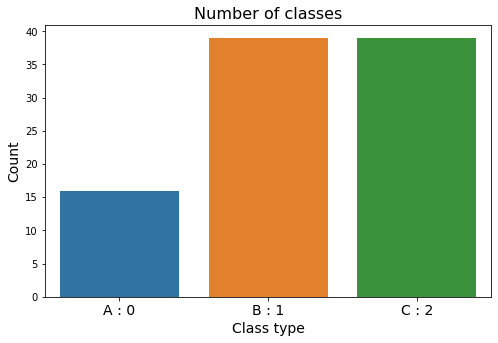

In [ ]:
# Counts for both classes
count_result = train_data['label'].value_counts()
print('Total : ', len(train_data))
print(count_result)

# Plot the results 
plt.figure(figsize=(8,5))
sns.countplot(x = 'label', data =  train_data)
plt.title('Number of classes', fontsize=16)
plt.xlabel('Class type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(len(count_result.index)), ['A : 0', 'B : 1', 'C : 2'], fontsize=14)
plt.show()

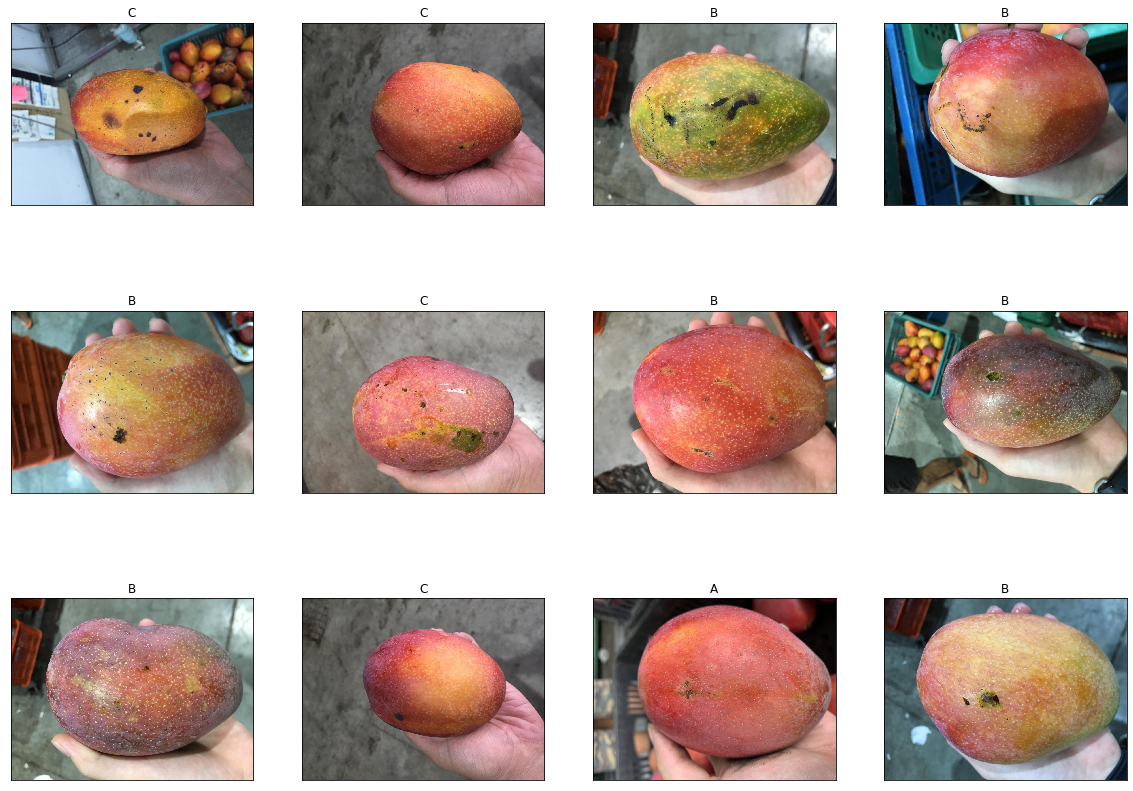

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(20,15))
for i, axi in enumerate(ax.flat):
    image = imread(train_data.image[i])
    axi.imshow(image, cmap='bone')
    if train_data.label[i] == 0: 
      mtype = 'A'
    elif train_data.label[i] == 1:
      mtype = 'B'
    else:
      mtype = 'C'
    axi.set_title(mtype)
    axi.set(xticks=[], yticks=[])

In [ ]:
train_data.to_numpy().shape

(94, 2)

In [ ]:
# ---------------------------------------------------------
#  1. Resizing all the images to 224x224 with 3 channels.
#  2. Then, normalize the pixel values.  
# ---------------------------------------------------------
def data_input(dataset):
    # print(dataset.shape)
    for image in dataset:
        im = cv2.imread(str(image))
        im = cv2.resize(im, (224,224))
        if im.shape[2] == 1:
            # np.dstack(): Stack arrays in sequence depth-wise (along third axis).
            # https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html
            im = np.dstack([im, im, im])
        
        # ----------------------------------------------------------------------------------------
        # cv2.cvtColor(): The function converts an input image from one color space to another. 
        # [Ref.1]: "cvtColor - OpenCV Documentation"
        #     - https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html
        # [Ref.2]: "Python计算机视觉编程- 第十章 OpenCV" 
        #     - https://yongyuan.name/pcvwithpython/chapter10.html
        # ----------------------------------------------------------------------------------------
        x_image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        
        # Normalization
        x_image = x_image.astype(np.float32)/255.
        return x_image

In [ ]:
# Import training dataset...
x_train, y_train = ([data_input(train_data.iloc[i][:]) for i in range(len(train_data))], 
                    [train_data.iloc[i][1] for i in range(len(train_data))])

# Convert the list into numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
    
print("Total number of validation examples: ", x_train.shape)
print("Total number of labels:", y_train.shape)

Total number of validation examples:  (94, 224, 224, 3)
Total number of labels: (94,)


In [ ]:
x_train[0]

array([[[0.4509804 , 0.5176471 , 0.61960787],
        [0.44705883, 0.5137255 , 0.6156863 ],
        [0.42352942, 0.49019608, 0.5921569 ],
        ...,
        [0.08235294, 0.10980392, 0.12156863],
        [0.09803922, 0.10980392, 0.12941177],
        [0.10588235, 0.10980392, 0.12941177]],

       [[0.49411765, 0.57254905, 0.67058825],
        [0.45490196, 0.53333336, 0.6313726 ],
        [0.4392157 , 0.5176471 , 0.6156863 ],
        ...,
        [0.07843138, 0.10588235, 0.11764706],
        [0.09803922, 0.10980392, 0.12941177],
        [0.09411765, 0.09803922, 0.11764706]],

       [[0.56078434, 0.64705884, 0.7411765 ],
        [0.5372549 , 0.62352943, 0.7176471 ],
        [0.49019608, 0.5764706 , 0.67058825],
        ...,
        [0.07058824, 0.09803922, 0.10980392],
        [0.08235294, 0.09411765, 0.11372549],
        [0.07843138, 0.08235294, 0.10196079]],

       ...,

       [[0.7607843 , 0.8666667 , 0.9490196 ],
        [0.7607843 , 0.8666667 , 0.9490196 ],
        [0.7607843 , 0

In [ ]:
y_train

array([2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 2, 1, 2, 1, 2, 2, 2, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 0, 1,
       1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       0, 2, 2, 2, 0, 0, 1, 0, 1, 0, 0, 1, 2, 2, 0, 2, 1, 0, 2, 1, 1, 0,
       1, 2, 2, 2, 1, 0])

## Starting Analysis from here

In [ ]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [ ]:
from keras.utils import np_utils

Using TensorFlow backend.


In [ ]:
y_train = np_utils.to_categorical(y_train, 3)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

In [ ]:
model = Sequential()


In [ ]:
model.add(Conv2D(32, (3,3), padding='same', input_shape=(224,224,3)))
model.add(Activation('relu'))

In [ ]:
model.add(MaxPooling2D(pool_size=(2,2)))

In [ ]:
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))

In [ ]:
model.add(MaxPooling2D(pool_size=(2,2)))

In [ ]:
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))

In [ ]:
model.add(MaxPooling2D(pool_size=(2,2)))

In [ ]:
model.add(Flatten())
model.add(Dense(200))
model.add(Activation('relu'))

In [ ]:
model.add(Dense(3))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='mse', optimizer=SGD(lr=0.05), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)      

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
94/94 [==============================] - 2s 16ms/step - loss: 0.2139 - acc: 0.4255
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 0.1902 - acc: 0.5426
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.1859 - acc: 0.5319
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 0.1776 - acc: 0.5957
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 0.2074 - acc: 0.5426
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 0.1874 - acc: 0.5213
Epoch 7/100
94/94 [==============================] - 0s 2ms/step - loss: 0.1655 - acc: 0.5957
Epoch 8/100
94/94 [==============================] - 0s 2ms/step - loss: 0.1566 - acc: 0.7128
Epoch 9/100
94/94 [==============================] - 0s 2ms/step - loss: 0.2094 - acc: 0.4787
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 0.1872 - acc: 0.5426
Epoch 11/100
94/94 [==============================] - 0s 2

In [ ]:
model_json = model.to_json()
open('aimango_model_cnn.json', 'w').write(model_json)
model.save_weights('aimango_weights_cnn.h5')